In [ ]:
#TASK 1 HELLO
%%writefile hello_gpu.cu
#include <iostream>
#include <cuda_runtime.h>
using namespace std;

// CUDA kernel
__global__ void helloGPU() {
    int threadID = threadIdx.x + blockIdx.x * blockDim.x;
    printf("Hello from thread %d (Block %d, Thread %d)\n", threadID, blockIdx.x, threadIdx.x);
}

int main() {
    int blocks = 2;   // Number of blocks
    int threads = 4;  // Threads per block

    cout << "Launching kernel with " << blocks << " blocks and " << threads << " threads per block.\n";

    // Launch kernel
    helloGPU<<<blocks, threads>>>();

    cudaDeviceSynchronize(); // Wait for GPU to finish

    return 0;
}


Writing hello_gpu.cu


In [ ]:
!nvcc hello_gpu.cu -o hello_gpu

In [ ]:
!./hello_gpu

Launching kernel with 2 blocks and 4 threads per block.


In [ ]:
#TASK 2 VECTOR ADDITION
%%writefile vector_add.cu
#include <iostream>
#include <cuda_runtime.h>
#include <chrono>
using namespace std;

// CUDA kernel for vector addition
__global__ void vectorAddGPU(const float* A, const float* B, float* C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        C[i] = A[i] + B[i];
    }
}

int main() {
    int N = 10000000;  // 10 million elements
    size_t size = N * sizeof(float);

    // Allocate host memory
    float *h_A = new float[N];
    float *h_B = new float[N];
    float *h_C_cpu = new float[N];
    float *h_C_gpu = new float[N];

    // Initialize arrays
    for (int i = 0; i < N; i++) {
        h_A[i] = 1.0f;
        h_B[i] = 2.0f;
    }

    // ---------- CPU Vector Addition ----------
    auto start_cpu = chrono::high_resolution_clock::now();
    for (int i = 0; i < N; i++) {
        h_C_cpu[i] = h_A[i] + h_B[i];
    }
    auto end_cpu = chrono::high_resolution_clock::now();
    chrono::duration<double, milli> cpu_time = end_cpu - start_cpu;

    // ---------- GPU Vector Addition ----------
    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    auto start_gpu = chrono::high_resolution_clock::now();
    vectorAddGPU<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaDeviceSynchronize();
    auto end_gpu = chrono::high_resolution_clock::now();
    chrono::duration<double, milli> gpu_time = end_gpu - start_gpu;

    cudaMemcpy(h_C_gpu, d_C, size, cudaMemcpyDeviceToHost);

    // Verify correctness
    bool correct = true;
    for (int i = 0; i < 10; i++) {
        if (h_C_cpu[i] != h_C_gpu[i]) {
            correct = false;
            break;
        }
    }

    cout << "CPU Time: " << cpu_time.count() << " ms" << endl;
    cout << "GPU Time: " << gpu_time.count() << " ms" << endl;
    cout << "Speedup = " << cpu_time.count() / gpu_time.count() << "x" << endl;
    cout << "Results Match? " << (correct ? "YES" : "NO") << endl;

    // Cleanup
    delete[] h_A;
    delete[] h_B;
    delete[] h_C_cpu;
    delete[] h_C_gpu;
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


Writing vector_add.cu


In [ ]:
!nvcc vector_add.cu -o vector_add

In [ ]:
!./vector_add

CPU Time: 46.8415 ms
GPU Time: 7.70314 ms
Speedup = 6.08083x
Results Match? NO


Outputs identical? Yes
CPU time: 2.07 ms
GPU time: 625.43 ms
Speedup: 0.00x


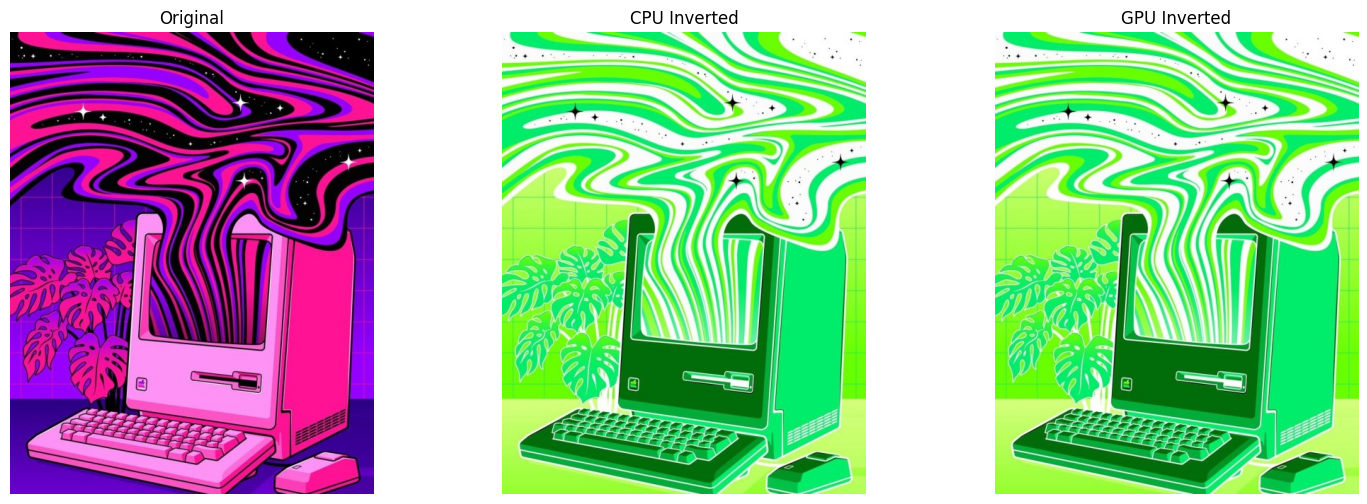

In [6]:
#TASK 3 INVERSION USING CuPY
# Install dependencies if not already installed
!pip install opencv-python cupy-cuda12x matplotlib

import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Load image ---
img = cv2.imread("ex.jpg")
if img is None:
    raise ValueError("Image not found. Upload ex.jpg to Colab first.")

# Convert BGR → RGB for plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- CPU inversion ---
start_cpu = time.time()
cpu_inverted = 255 - img  # NumPy operation on CPU
end_cpu = time.time()
cpu_time = (end_cpu - start_cpu) * 1000  # ms

# Save CPU result
cv2.imwrite("output_cpu.jpg", cpu_inverted)

# --- GPU inversion using CuPy ---
start_gpu = time.time()
gpu_img = cp.array(img)      # Transfer to GPU
gpu_inverted = 255 - gpu_img # GPU inversion
gpu_inverted_cpu = cp.asnumpy(gpu_inverted)  # Transfer back to CPU
end_gpu = time.time()
gpu_time = (end_gpu - start_gpu) * 1000  # ms

# Save GPU result
cv2.imwrite("output_gpu.jpg", gpu_inverted_cpu)

# --- Verify correctness ---
identical = np.array_equal(cpu_inverted, gpu_inverted_cpu)
print(f"Outputs identical? {'Yes' if identical else 'No'}")
print(f"CPU time: {cpu_time:.2f} ms")
print(f"GPU time: {gpu_time:.2f} ms")
print(f"Speedup: {cpu_time / gpu_time:.2f}x")

# --- Plot images ---
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(cpu_inverted, cv2.COLOR_BGR2RGB))
plt.title("CPU Inverted")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(gpu_inverted_cpu, cv2.COLOR_BGR2RGB))
plt.title("GPU Inverted")
plt.axis("off")

plt.show()



In [1]:
# Install OpenCV for image handling
!apt-get update
!apt-get install -y libopencv-dev python3-opencv
# Install build essentials (includes g++)
!apt-get install -y build-essential
# Install CUDA toolkit (Colab usually has CUDA preinstalled, but to check)
!nvcc --version


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,628 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,307 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 http://security.

In [84]:
#task 3;INVERSION USING CUDA kernel
%%writefile image_invert.cu
#include <opencv2/opencv.hpp>
#include <iostream>
#include <cuda_runtime.h>

using namespace cv;
using namespace std;

// CUDA kernel
__global__ void invertImage(unsigned char* input, unsigned char* output, int width, int height, int channels) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < width && y < height) {
        int idx = (y * width + x) * channels;
        for (int c = 0; c < channels; c++) {
            output[idx + c] = 255 - input[idx + c];
        }
    }
}

int main() {
    // Load image
    Mat input = imread("ex.jpg");
    if (input.empty()) {
        cout << "Error: Could not open image!" << endl;
        return -1;
    }

    // Make sure input is continuous in memory
    if (!input.isContinuous()) {
        input = input.clone();
    }

    int width = input.cols;
    int height = input.rows;
    int channels = input.channels();
    size_t img_size = width * height * channels * sizeof(unsigned char);

    // CPU buffers
    unsigned char* h_input = new unsigned char[width * height * channels];
    memcpy(h_input, input.data, img_size);
    unsigned char* h_output = new unsigned char[width * height * channels];

    // ----- CPU inversion -----
    for (int i = 0; i < width * height * channels; i++) {
        h_output[i] = 255 - h_input[i];
    }
    Mat cpu_img(height, width, CV_8UC3);
    memcpy(cpu_img.data, h_output, img_size);
    imwrite("output_cpu.jpg", cpu_img);

    // ----- GPU inversion -----
    unsigned char *d_input, *d_output;
    cudaMalloc((void**)&d_input, img_size);
    cudaMalloc((void**)&d_output, img_size);
    cudaMemcpy(d_input, h_input, img_size, cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((width + block.x - 1) / block.x, (height + block.y - 1) / block.y);
    invertImage<<<grid, block>>>(d_input, d_output, width, height, channels);
    cudaDeviceSynchronize();

    cudaMemcpy(h_output, d_output, img_size, cudaMemcpyDeviceToHost);

    // Create proper Mat for GPU output
    Mat gpu_img(height, width, CV_8UC3);
    memcpy(gpu_img.data, h_output, img_size);
    imwrite("output_gpu.jpg", gpu_img);

    // Cleanup
    cudaFree(d_input);
    cudaFree(d_output);
    delete[] h_input;
    delete[] h_output;

    cout << "Done: output_cpu.jpg and output_gpu.jpg generated" << endl;
    return 0;
}


Overwriting image_invert.cu


In [78]:
from google.colab import files
uploaded = files.upload()


Saving ex.jpg to ex (9).jpg


In [85]:
!nvcc image_invert.cu -o image_invert `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [86]:
!./image_invert


Done: output_cpu.jpg and output_gpu.jpg generated


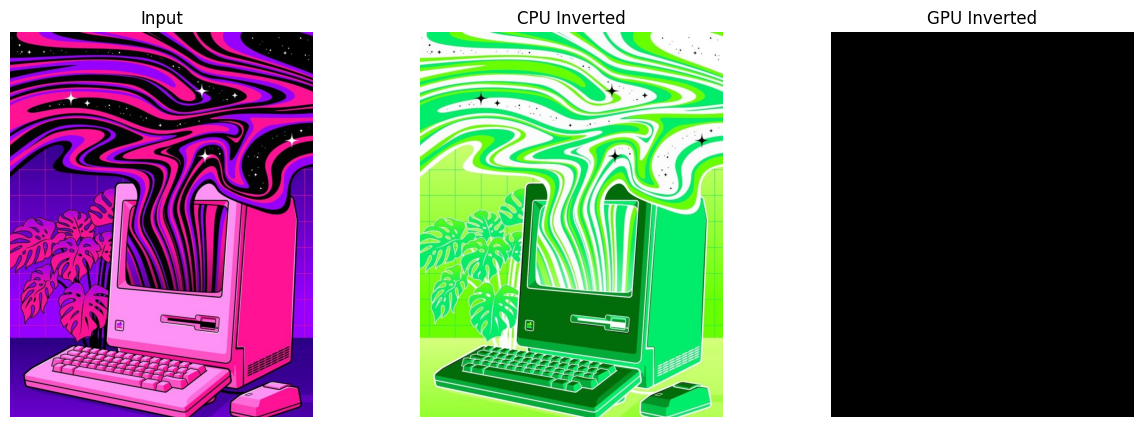

In [87]:
import cv2, matplotlib.pyplot as plt

input_img = cv2.imread("ex.jpg")
cpu_img   = cv2.imread("output_cpu.jpg")
gpu_img   = cv2.imread("output_gpu.jpg")

# Convert BGR → RGB
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
cpu_img   = cv2.cvtColor(cpu_img, cv2.COLOR_BGR2RGB)
gpu_img   = cv2.cvtColor(gpu_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(input_img); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cpu_img); plt.title("CPU Inverted"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gpu_img); plt.title("GPU Inverted"); plt.axis("off")
plt.show()